# **The Goal**
Our job is to predict the sales price for each house. Below are some questions I considered during my analysis to identify patterns. I hope you find this useful. :)

Please let me know if you have any feedback on my notebook.


# **1. Import libraries and loading data**

In [1]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visulazing librarires
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("paper", font_scale= 1.25)

# Import preprocessing packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

# Import models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Round the number to two decimal places and display it.
pd.set_option('display.float_format', lambda x: '{:0.2f}'.format(x))

print('Done! All packges loaded.')

Done! All packges loaded.


In [2]:
# Create a function to show the count and percentage of missing values in each column, and the column types.
def nulls_count(df):
    " Create a function to show the count and percentage of missing values in each column, and the column types."
    #Identify and count the missing values in each feature.
    missing_num= df.isna().sum()
    # Show only features with Nulls.
    missing_num= missing_num[missing_num >0].to_frame()
    #Calculate the percentage of null values.
    percente= (missing_num/ dfs.shape[0])*100

    # Create a DataFrame of null values.
    nulls_df= pd.DataFrame(
                            {"Nulls_num": missing_num.iloc[:, -1],
                            "percentage": percente.iloc[:, -1],
                           "col_type": dfs[missing_num.index].dtypes}
                          ).sort_values("Nulls_num", ascending= False)

    # Show nulls count
    return nulls_df.drop(['SalePrice'])

In [3]:
# Create a function to split the concatenated DataFrame into the train and test DataFrames
def split_df(df):
    " Create a function to split the concatenated DataFrame into the train and test DataFrames"
    train= df.iloc[:train_df.shape[0]]
    test= df.iloc[train_df.shape[0]:].drop("SalePrice", axis= 1)
    
    # Set dataframe names
    train.name= "Training set"
    test.name= "Test set"
    return train, test

In [4]:
# Create a function to show the number of outliers per column.
def check_skewness_outliers(df):
    " Create a function to show the number of outliers per column."
    # numeric column list
    numeric_cols= df.select_dtypes(include= 'number').columns

    # compute features skewness
    skewed= df.skew(numeric_only= True).sort_values(ascending= False).to_frame().reset_index()
    skewed.columns= ['feature', 'skewness']

    # Identify the outliers and count them.
    outliers= []
    for col in numeric_cols:
        # Visualize column distribution.
    #     sns.distplot(df[col], bins=20)
    #     plt.show()

        # Count the outliers in numeric columns.
        quantile_25= df[col].quantile(0.25)
        quantile_75= df[col].quantile(0.75)
        IQR= quantile_75 - quantile_25
        upper= quantile_75 + 1.5* IQR
        lower= quantile_25 - 1.5* IQR 
        outlier_df= df[(df[col]> upper) | (df[col]< lower)]
        outliers.append(outlier_df[col].nunique())
    #     print("-"*50, "\n")

    # Create a DataFrame to store the outlier count
    outlier_df= skewed.assign(outliers_num= outliers).sort_values('outliers_num', ascending= False).reset_index(drop= True)
    # Show only features that have outliers.
    return outlier_df[outlier_df.iloc[:, 2] > 0]

In [5]:
# Load data
train_df= pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df= pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Concatenate datasets into one DataFrame for cleaning.
dfs= pd.concat([train_df, test_df]).drop("Id", axis= 1)

# Set dataframe names
train_df.name= "Training set"
test_df.name= "Test set"

In [6]:
# View a sample of 5 rows from the training set.
train_df.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1322,1323,60,RL,107.00,10186,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,190000
754,755,20,RL,61.00,7930,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,156000
1249,1250,20,RL,60.00,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,119000
1426,1427,60,RL,81.00,10944,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,271000
1449,1450,180,RM,21.00,1533,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2006,WD,Abnorml,92000


In [7]:
# View trainig set info
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

In [8]:
# View Test set info
train_df['SalePrice'].describe()

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64

# **2. Cleaning data**

## 2.1 handle missing values

* **First**, we will handle missing values in order to understand the data comprehensively.

In [9]:
# Show number of nulls
nulls_count(dfs)

,Nulls_num,percentage,col_type
PoolQC,2909,99.66,object
MiscFeature,2814,96.40,object
Alley,2721,93.22,object
Fence,2348,80.44,object
MasVnrType,1766,60.50,object
FireplaceQu,1420,48.65,object
LotFrontage,486,16.65,float64
GarageCond,159,5.45,object
GarageYrBlt,159,5.45,float64
GarageFinish,159,5.45,object


* The **data description** file says that all the null values in the following columns denote null values. Therefore, we will replace them with None.

In [10]:
# Columns list from data descriptions.
cols= ['Alley', 'FireplaceQu', 'Fence', 'PoolQC', 'MiscFeature', 'MasVnrType',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
        'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageType']
# Fill missing values by None.
for c in cols:
    dfs[c].fillna('None', inplace= True)

* **LotFrontage** is the linear feet of street connected to the property in any place. It depends on the zoning rules of the neighborhood and the location of the property. Therefore, we will impute the missing LotFrontage values by using the median LotFrontage value for each Neighborhood and LotConfig.

In [11]:
# Fill Nulls in LotFrontage column.
dfs['LotFrontage']= dfs.groupby(['Neighborhood', 'LotConfig'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
dfs['LotFrontage']= dfs.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

* For **MasVnrArea**, we fill the missing values with the median MasVnrArea value for each MasVnrType category.

In [12]:
# Create a dictionary of the median MasVnrArea values for each MasVnrType group.
masvnr_dict= dfs.groupby('MasVnrType')['MasVnrArea'].median().to_dict()
# Fill Nulls in MasVnrArea column.
dfs['MasVnrArea']= dfs['MasVnrArea'].fillna(dfs['MasVnrType'].map(masvnr_dict))

* For **MSZoning**, we fill the missing values with the median MSZoning value for each Neighborhood group.

In [13]:
# Fill the missing values in the MSZoning column with the most frequent MSZoning value for each Neighborhood group.
dfs['MSZoning']= dfs.groupby(['Neighborhood'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

* For **TotalBsmtSF**, **BsmtUnfSF**, **BsmtFullBath**, **BsmtHalfBath**, **BsmtFinSF1**,and **BsmtFinSF2**, there is No basement in the property. Therefore, they are equal to 0.

In [14]:
# Fill Nulls in columns by 0.
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    dfs[col].fillna(0, inplace= True)

* For **other** categorical and numerical columns, we will impute missing values with the mode and median, respectively.

In [15]:
# Fill object columns by mode.
for col in ['Utilities', 'Functional', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType', 'Electrical']:
    dfs[col].fillna(dfs[col].mode()[0], inplace= True)
    
# Fill numeric columns by median.
for col in ['GarageCars', 'GarageArea']:
    dfs[col].fillna(dfs[col].median(), inplace= True)
    
# Check Nulls.
nulls_count(dfs)

,Nulls_num,percentage,col_type


## 2.2 Outliers

In [16]:
# View outliers
check_skewness_outliers(dfs)

,feature,skewness,outliers_num
0,BsmtHalfBath,3.93,271
1,GarageArea,0.24,182
2,EnclosedPorch,4.01,140
3,LotArea,12.83,124
4,MoSold,0.20,120
5,BedroomAbvGr,0.33,96
6,LotFrontage,1.44,66
7,YearBuilt,-0.60,58
8,OverallCond,0.57,57
9,PoolArea,16.91,45


* We have many outliers in most of our numeric features. Therefore, we must standardize or normalize these features before modeling to avoid bias.

## 2.3 Duplicates

In [17]:
# Check duplicates
print(f"- There is {dfs.duplicated().sum()} duplicates in the dataset.")

- There is 0 duplicates in the dataset.


## 2.4 Change features types
* There are many features in the dataset that are ordinal categories. It's better to replace them with numbers to be more interpretable.

In [18]:
cols1= ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']
cols2= ['ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC'] 
cols3= ['BsmtFinType1', 'BsmtFinType2']
# replace dictionary
for col in cols1:
    dfs[col].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}, inplace= True)

for col in cols2:
    dfs[col].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, inplace= True)

for col in cols3:
    dfs[col].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None':0}, inplace= True)

In [19]:
# Columns has ordinal categories.
dict1={
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}, 
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}, 
    'CentralAir': {'Y': 1, 'N': 0}, 
    'PavedDrive' : {'N': 0, 'P': 1, 'Y': 2}, 
    'Fence' : {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0}, 
    'Alley': {'Pave': 2, 'Grvl': 1,  'None': 0}, 
    'LandSlope': {'Gtl': 2, 'Mod': 1, 'Sev':0}, 
    'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, "None": 0}, 
    'Street': {'Grvl': 0, 'Pave': 1}, 
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3':1}, 
    'Utilities': {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1}, 
    'MSSubClass': {20: 1, 30: 2, 40: 3, 45: 4, 50: 5, 60: 6, 70: 7, 75:8, 80:9, 85:10, 90:11, 120: 12, 150:13, 160: 14, 180: 15, 190: 16}
    }

# replacement
for col, values in dict1.items():
    dfs[col].replace(values, inplace= True)

* After finishing cleaning data, we will return to the Training and Test sets.

In [20]:
# get the Training and test sets
train, test= split_df(dfs)

# view dataframes structures
train.shape , test.shape

((1460, 80), (1459, 79))

# **3. Exploring data and find patterns**

[Text(0.5, 1.0, 'SalePrice distriburion')]

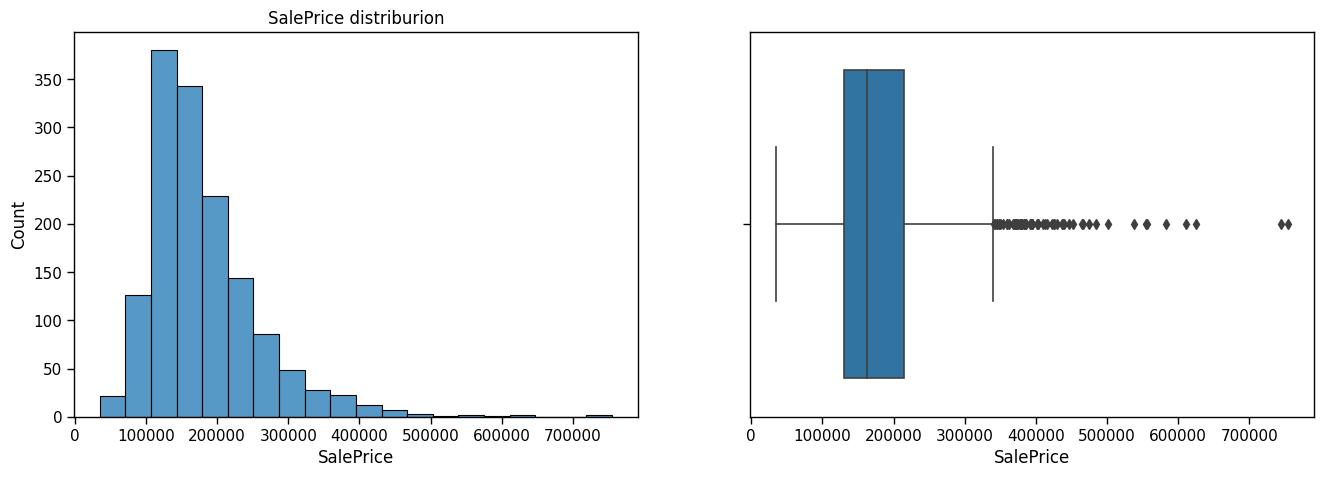

In [21]:
# Target variable distribution
fig, ax1= plt.subplots(1, 2, figsize= (16, 5))

# SalePrice histogram
sns.histplot(x="SalePrice", data= train, bins= 20, ax= ax1[0])

# SalePrice boxplot to show outliers
sns.boxplot(x="SalePrice", data= train, ax= ax1[1])

ax1[0].set(title= "SalePrice distriburion")

**• Which Neighborhood has the highest price and number of sales?**

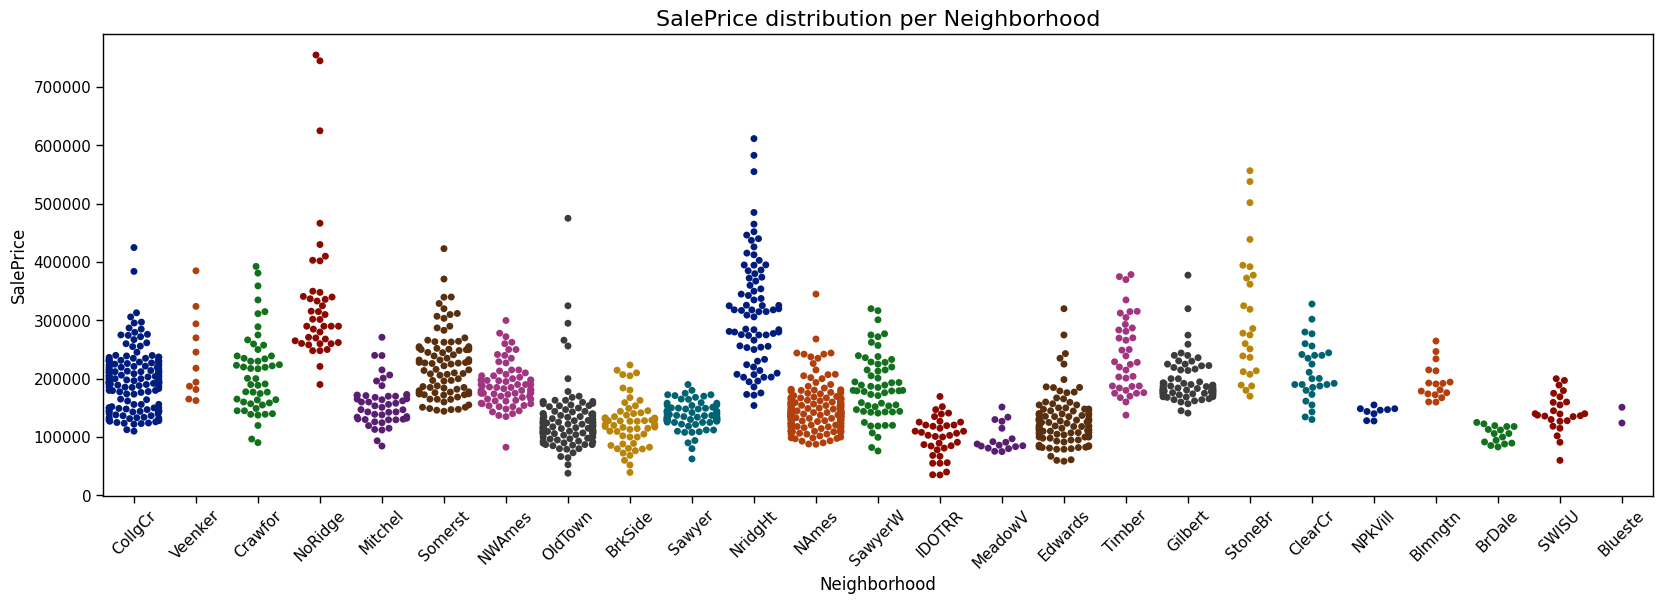

In [22]:
# Plot SalePrice dist per Neighborhood
plt.figure(figsize= (20,6))
sns.swarmplot(y= "SalePrice", x="Neighborhood", palette= "dark", data= train)
plt.title( "SalePrice distribution per Neighborhood", fontdict= {"fontsize": 16})
plt.xticks(rotation=45)
plt.show()

**• Is LotConfig effect on price?**

Text(0.5, 1.0, 'House price distribution by Lot configuration.')

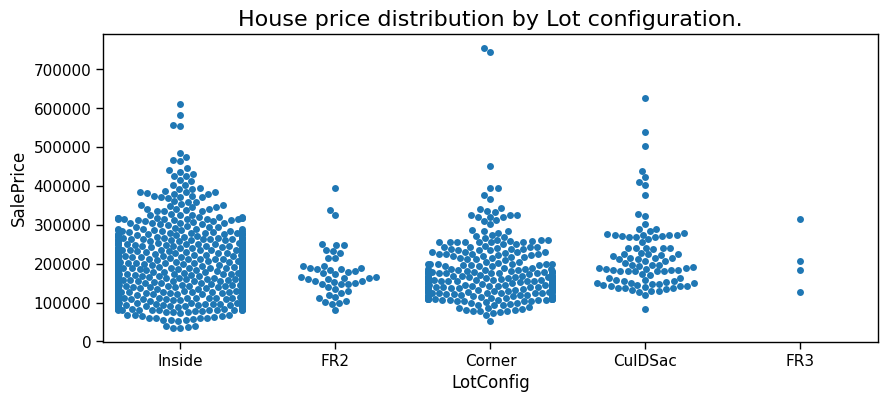

In [23]:
# Plot House price distribution by Lot configuration.
plt.figure(figsize= (10, 4))

sns.swarmplot(data= train, x='LotConfig', y= "SalePrice")

plt.title("House price distribution by Lot configuration.", fontdict= {'fontsize': 16})

Text(0.5, 1.0, 'House price distribution by year built and sold.')

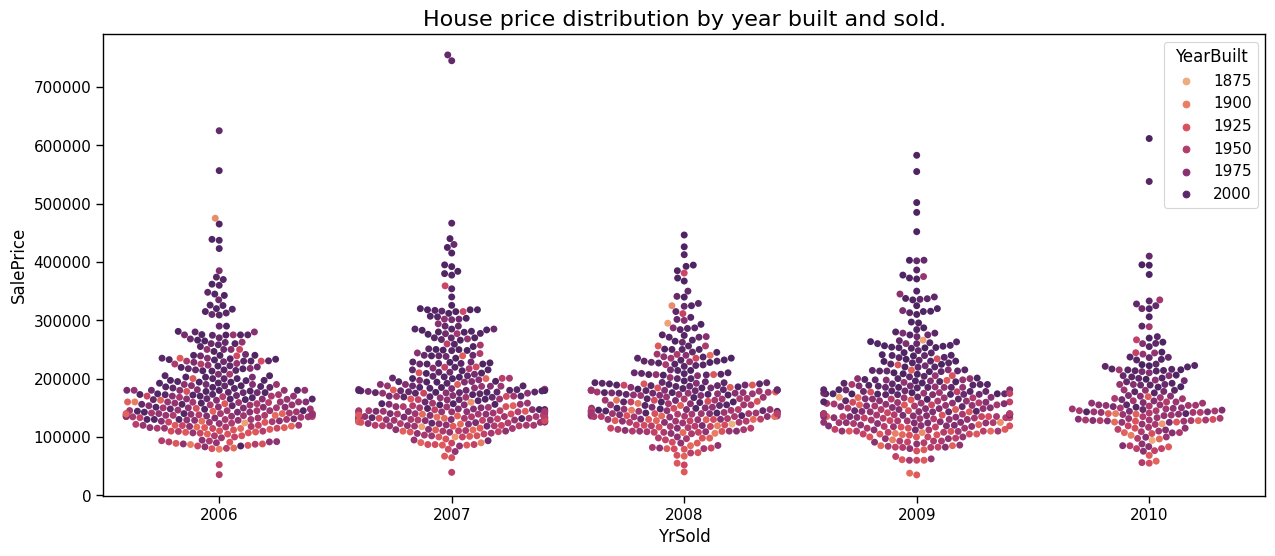

In [24]:
# plot the house price distribution by year built and sold.
plt.figure(figsize= (15, 6))

sns.swarmplot(data= train, x='YrSold', y= "SalePrice", hue= 'YearBuilt', palette= 'flare')

plt.title("House price distribution by year built and sold.", fontdict= {'fontsize': 16})

**• The Condition1 effect on price?**

Text(0.5, 1.0, 'House price distribution per Proximity to various conditions.')

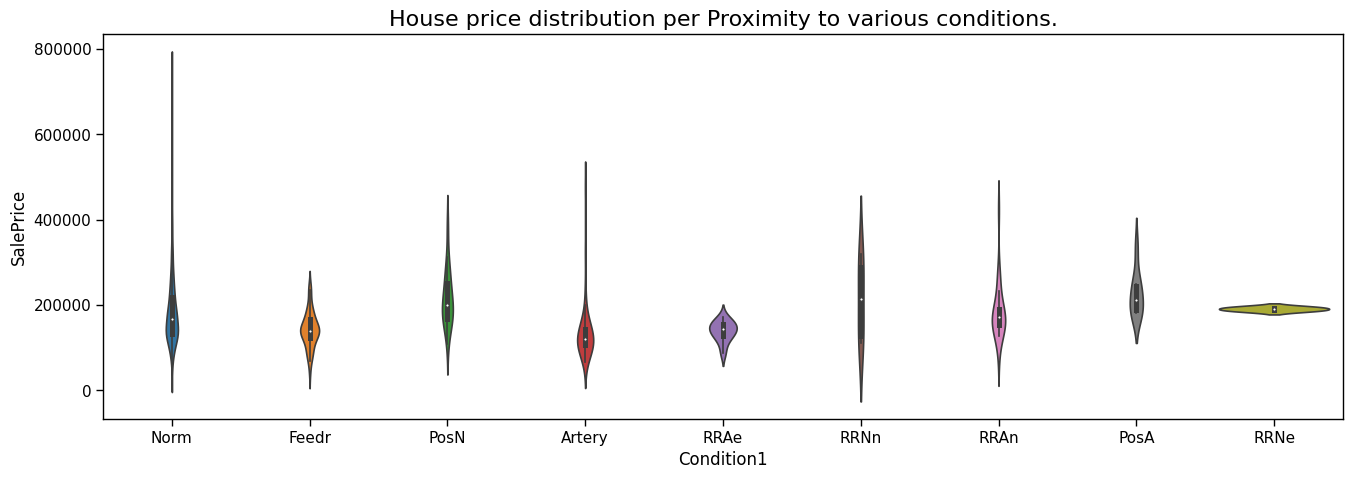

In [25]:
plt.figure(figsize= (16, 5))
sns.violinplot(data= train, x='Condition1', y= "SalePrice")

plt.title("House price distribution per Proximity to various conditions.", fontdict= {'fontsize': 16})

Text(0.5, 1.0, 'House price distribution per Rating of basement finished area.')

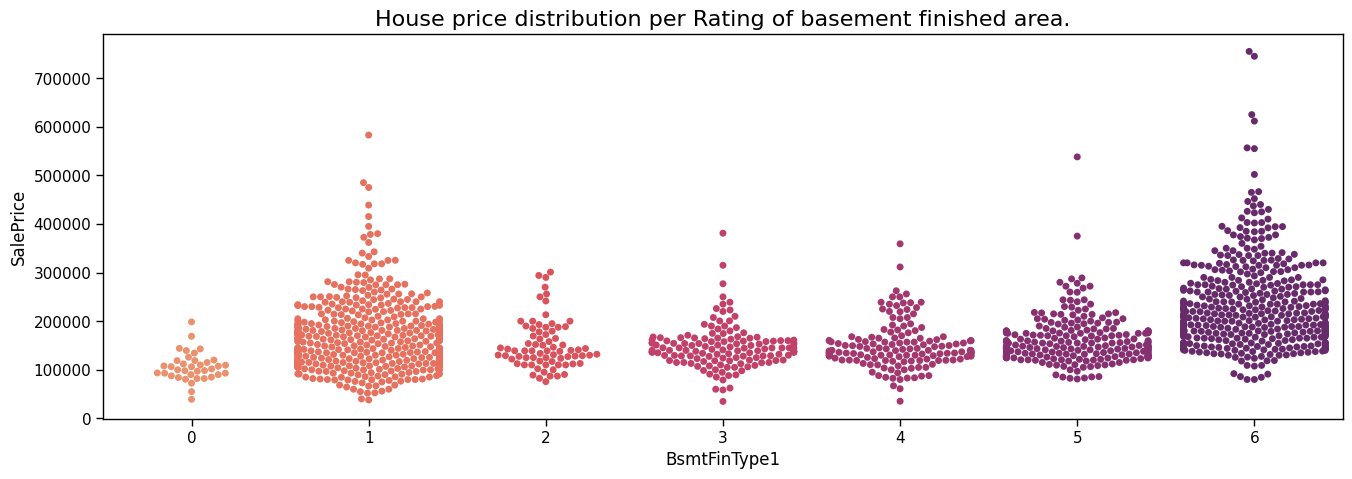

In [26]:
# Plot House price distribution by basement finished area.
fig, ax1= plt.subplots(1, 1, figsize= (16, 5))
sns.swarmplot(data= train, x='BsmtFinType1', y= "SalePrice", palette= 'flare')

plt.title("House price distribution per Rating of basement finished area.", fontdict= {'fontsize': 16})

**• What is the price difference between dwelling types?**

Text(0.5, 1.0, 'House price distribution in each dwelling type.')

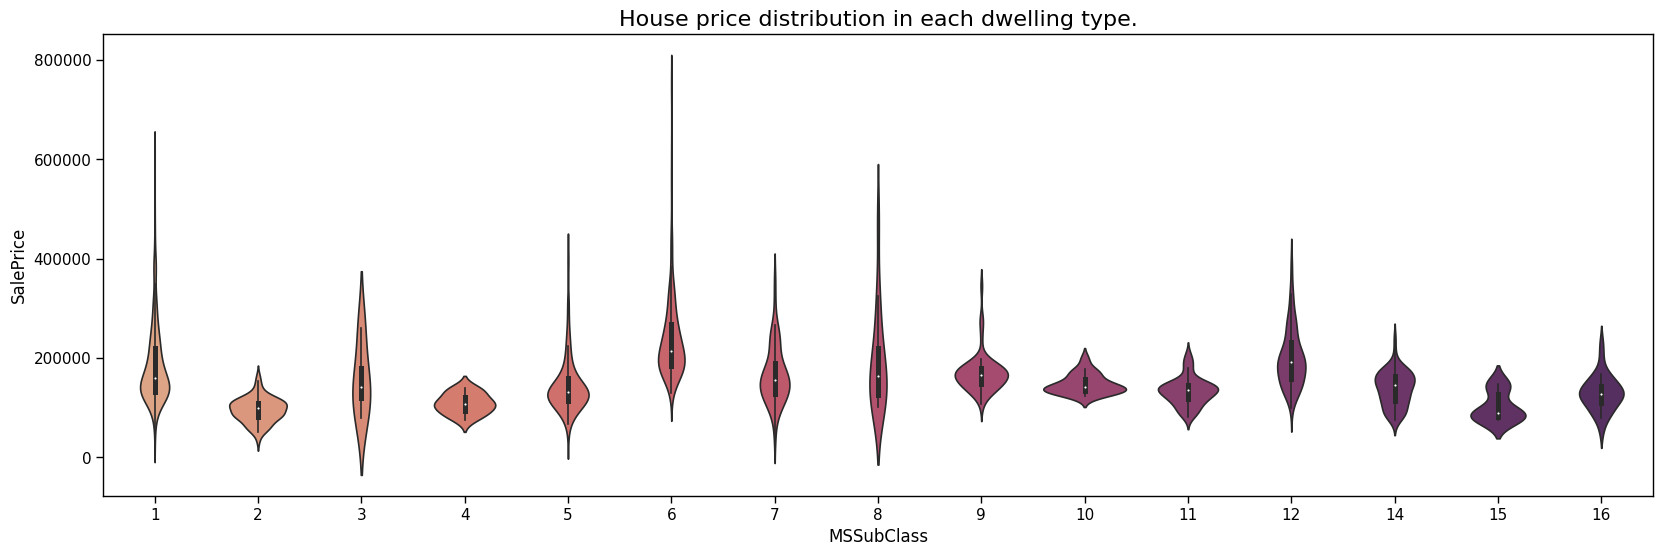

In [27]:
# plot House price distribution in each dwelling type
plt.figure(figsize= (20,6))
sns.violinplot(data= train, x='MSSubClass', y= "SalePrice", palette= 'flare')

plt.title("House price distribution in each dwelling type.", fontdict= {'fontsize': 16})

Text(0.5, 1.0, 'House price averages in each zoning classification.')

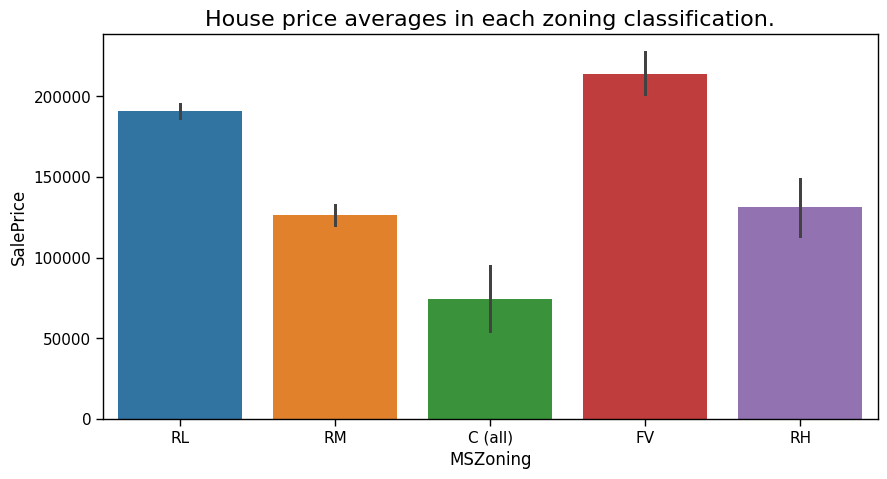

In [28]:
# plot SalePrice averge per MSZoning.
fig, ax1= plt.subplots(1, 1, figsize= (10, 5))
sns.barplot(data= train, x= 'MSZoning', y= "SalePrice")

plt.title("House price averages in each zoning classification.", fontdict= {'fontsize': 16})

Text(0.5, 1.0, 'SalePrice distribution per Sale Condition')

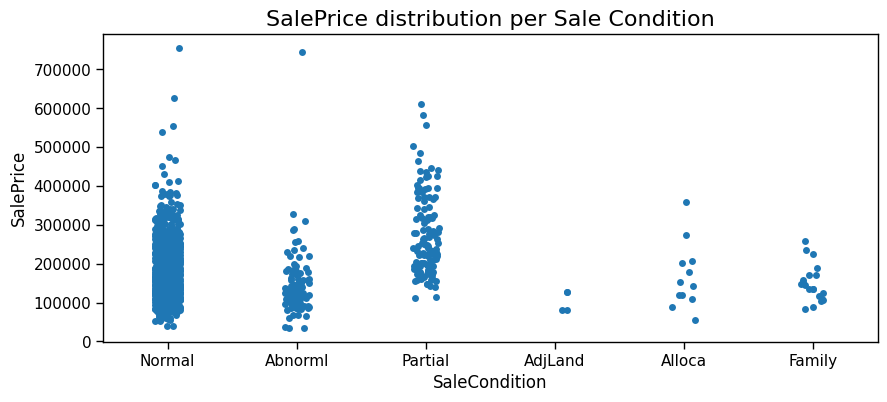

In [29]:
# Plot between Sale pice and Sale Condition.
plt.figure(figsize= (10,4))
sns.stripplot(y= "SalePrice", x="SaleCondition", data= train)
plt.title( "SalePrice distribution per Sale Condition", fontdict= {"fontsize": 16})

Text(0.5, 1.0, 'SalePrice distribution per Sale type')

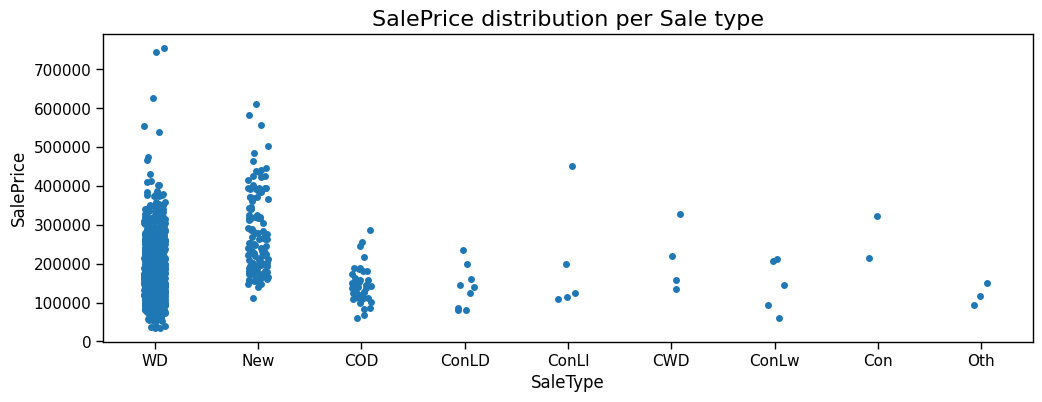

In [30]:
# Plot between Sale pice and Sale type.
plt.figure(figsize= (12,4))
sns.stripplot(y= "SalePrice", x="SaleType", data= train)
plt.title( "SalePrice distribution per Sale type", fontdict= {"fontsize": 16})

Text(0.5, 1.0, 'Correlation of the target variable with other features')

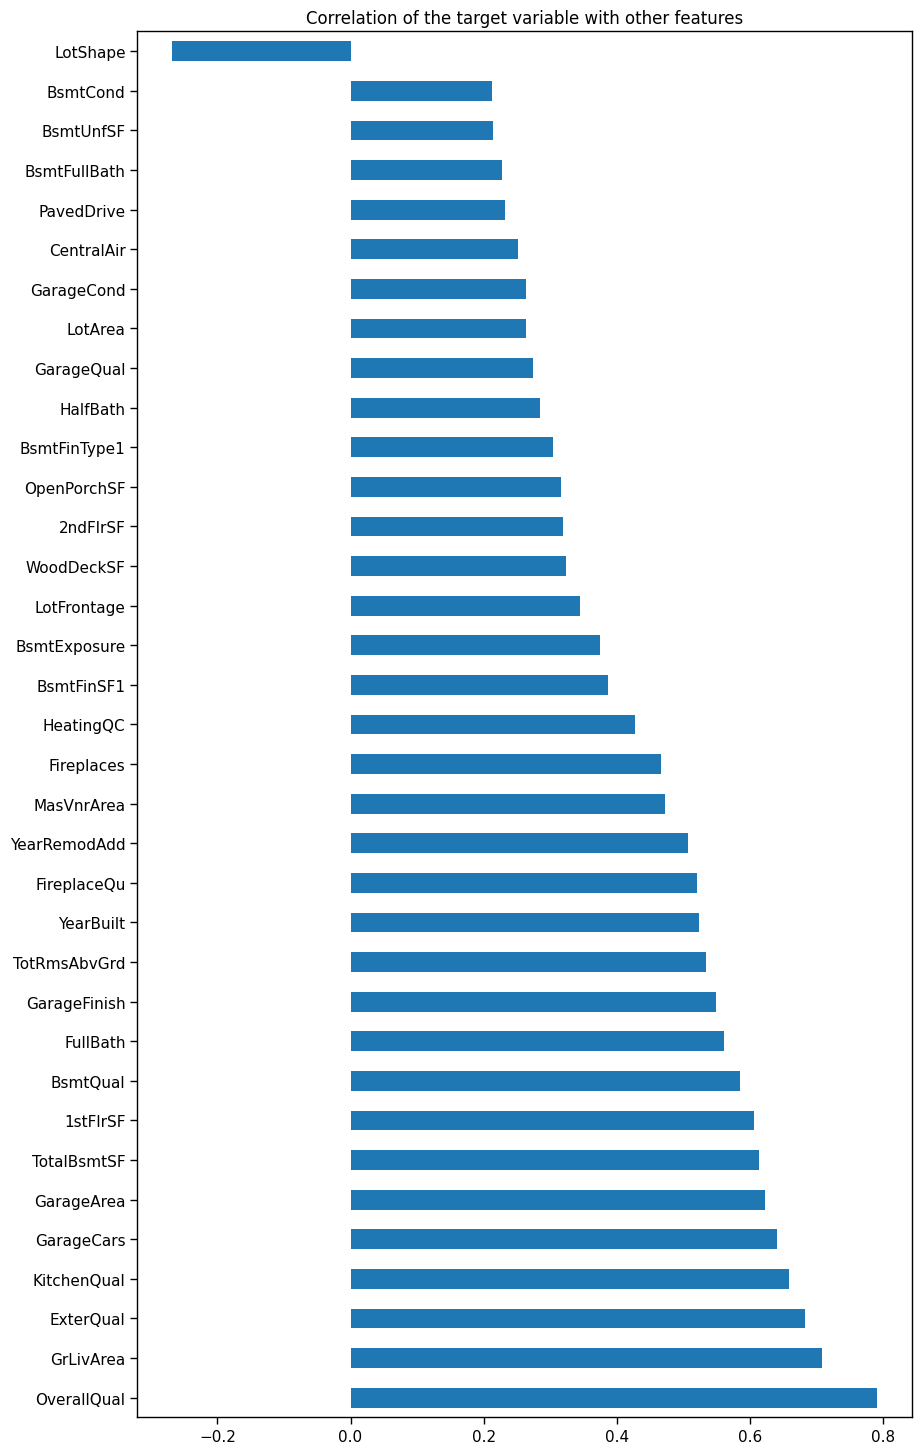

In [31]:
# Find correlations after dropping
corr= train.corr(numeric_only= True)

# get correlation with the target variable only
target_corr= corr["SalePrice"].sort_values(ascending= False)
# show high correlations only
high_target_corr= target_corr[target_corr.abs() > 0.2]
high_target_corr_cols= high_target_corr.index.to_list() 

# plot correlations
plt.figure(figsize= (10, 18))
high_target_corr.drop('SalePrice').plot(kind= 'barh')
plt.title('Correlation of the target variable with other features')

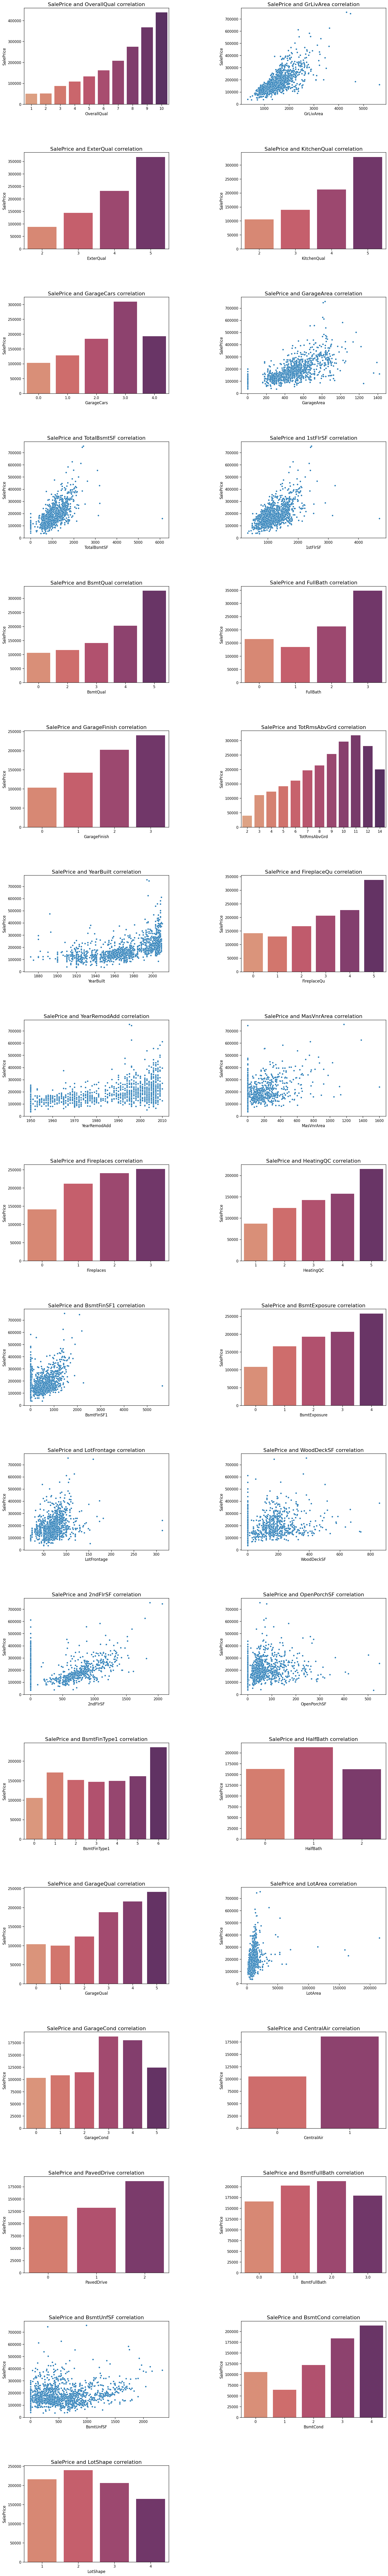

In [32]:
# set plots settings
rows_num= 1+len(high_target_corr_cols) //2
plt.figure(figsize= (20, 150))
plt.subplots_adjust(wspace= 0.5, hspace=0.5)

# plot plots
for i, col in enumerate(high_target_corr_cols[1:], 1):
    plt.subplot(rows_num, 2, i)
    if train[col].nunique() <= 14:
        sns.barplot(data=train, x= col, y= "SalePrice", ci= None, palette= 'flare')
    else:
        sns.scatterplot(data=train, x= col, y= "SalePrice")
        
    plt.title(f"SalePrice and {col} correlation",  fontdict={'fontsize': 16})

In [33]:
# Show extrame correlations
# Find features with high correlations. 
corr_stacked= corr.stack()
corr_stacked= corr_stacked[(corr_stacked.abs()>= 0.9) & (corr_stacked.abs()< 1)]
# Show unique values
corr_stacked.drop_duplicates()

GarageQual  GarageCond   0.96
dtype: float64

In [34]:
# drop Extreme correlation to avoid bias
train.drop("GarageQual", axis=1 ,inplace= True)
test.drop("GarageQual", axis=1 ,inplace= True)

# **4. drop redundant features**

In [35]:
# Drop confusing columns
print('columns number before dropping: ', dfs.shape[1])
# categorical columns
cat_cols= dfs.select_dtypes(exclude= 'number').columns

# create dropped column names list
dropped_cols= []
for col in cat_cols:
    high_value= dfs[col].value_counts(normalize= True)[0]
    if high_value > 0.97:
        dropped_cols.append(col)
        dfs.drop(col, axis= 1, inplace= True)
print("the columns that will be dropped: ", dropped_cols)
print('columns number after dropping: ', dfs.shape[1])

columns number before dropping:  80
the columns that will be dropped:  ['Condition2', 'RoofMatl', 'Heating']
columns number after dropping:  77


In [36]:
# dummies categorical features
dfs= pd.get_dummies(dfs, drop_first= True)

# get the Training and test sets
train, test= split_df(dfs)

train.sample(5)

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
193,14,24.00,2522,1,0,4,4,2,7,5,...,False,False,False,False,True,False,False,False,True,False
613,1,70.00,8402,1,0,4,4,2,5,5,...,False,False,True,False,False,False,False,False,False,True
518,6,44.50,9531,1,0,3,4,2,6,5,...,False,False,False,False,True,False,False,False,True,False
1415,12,51.00,3635,1,0,4,4,2,7,5,...,False,False,False,False,True,False,False,False,True,False
1203,1,75.00,9750,1,0,4,4,2,7,5,...,False,False,False,False,True,False,False,False,True,False


# **5.Modeling**

In [37]:
# Store train and Target variables
X= train.drop(['SalePrice'], axis=1).values
# Normalize The target variable by taking the logarithm
y= np.log1p(train['SalePrice']).values

# Set the seed for reproducibility.
SEED= 616

In [38]:
# Split training set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= SEED)

# shuffle data
kf= KFold(n_splits=8, shuffle= True, random_state= SEED)

   * As we said before, many features have high variance, so we will normalize them.

In [39]:
# Define standrized model
scaler= StandardScaler()
# Normalize data to make all features have the same scale.
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

### . Evaluate best model to use.

In [40]:
# Create models dict
models= {"lasso": Lasso(random_state= SEED), "Ridge": Ridge(random_state= SEED), "SVR": SVR(),
    "rfr": RandomForestRegressor(random_state= SEED), "gbr": GradientBoostingRegressor(random_state= SEED), 
         "Adaboost regression": AdaBoostRegressor(random_state= SEED)}
# cv results lists 
cv_results= []
# run models
for name, model in models.items():
    kf= KFold(n_splits=8, shuffle= True, random_state= SEED)
    cv_scores= cross_val_score(model, X_train_scaled, y_train, cv= kf)
    cv_results.append(cv_scores)
    print(f"- {name} model mean error score = {cv_scores.mean():0.3f}")

- lasso model mean error score = -0.011
- Ridge model mean error score = 0.709
- SVR model mean error score = 0.774
- rfr model mean error score = 0.851
- gbr model mean error score = 0.879
- Adaboost regression model mean error score = 0.807


* **Lasso** and **ridge** regression models tend to overfit, resulting in poor performance. By carefully tuning their hyperparameters, we can improve their predictive accuracy.

In [41]:
# build stochastic Gradient Boosting Regressor
sgbr= GradientBoostingRegressor(learning_rate= 0.1, max_depth= 3, min_samples_split= 35, n_estimators= 300, subsample= 0.8, random_state= SEED)

# fit model
sgbr.fit(X_train_scaled, y_train)

# Evaluate model score
sgbr.score(X_test_scaled, y_test)

0.9166675401360256

In [42]:
# build Ridge model with best parameters
model= Ridge(random_state= SEED)

# params dict
params= {
    "alpha": [0.01, 0.1, 1.0, 10.0, 100.0], 
    'fit_intercept': [True, False], 
    'solver': ['auto', 'lsqr']
}
# Instantiate GridSearchCV algorithm to perform hyperparameter tuning
model_cv= GridSearchCV(model, param_grid= params, cv= kf)

# fit model
model_cv.fit(X_train_scaled, y_train)

# save the model with the best parameter
ridge= model_cv.best_estimator_
# show best score
print(model_cv.best_score_)

# show best params
print(model_cv.best_params_)

0.8254152229461801
{'alpha': 100.0, 'fit_intercept': True, 'solver': 'auto'}


In [43]:
# build Ridge model with best parameters
model= Lasso(random_state= SEED)

# params dict
params= {
    "alpha": [0.01, 0.1, 1.0, 10.0, 100.0], 
    'fit_intercept': [True, False], 
    'max_iter': [1000, 2000, 5000]
}
# Instantiate GridSearchCV algorithm to perform hyperparameter tuning
model_cv= GridSearchCV(model, param_grid= params, cv= kf)

# fit model
model_cv.fit(X_train_scaled, y_train)

# save the model with the best parameter
lasso= model_cv.best_estimator_
# show best score
print(model_cv.best_score_)

# show best params
print(model_cv.best_params_)

0.8328530307157727
{'alpha': 0.01, 'fit_intercept': True, 'max_iter': 1000}


In [44]:
# Create a list of base estimators
estimators= [ ('Ridge', ridge), 
             ('lasso', lasso),
            ('sgbr', sgbr)]

# Instantiate and fit the VotingRegressor model
voting = VotingRegressor(estimators= estimators, weights= [0.2, 0.2, 0.6]).fit(X_train_scaled, y_train)

In [45]:
# Over/underfitting check 
cv_scores= np.sqrt(-cross_val_score(voting, X_train_scaled, y_train, cv= kf, scoring="neg_mean_squared_error"))
y_pred_train= voting.predict(X_train_scaled)
y_pred_test= voting.predict(X_test_scaled)
print(f"- voting regressor model CV mean error score = {np.mean(cv_scores):0.3f}")    
print(f"- voting regressor model train mean error score = {np.sqrt(mean_squared_error(y_train, y_pred_train)):0.3f}")    
print(f"- voting regressor model test mean error score = {np.sqrt(mean_squared_error(y_test, y_pred_test)):0.3f}")

- voting regressor model CV mean error score = 0.135
- voting regressor model train mean error score = 0.074
- voting regressor model test mean error score = 0.112


In [46]:
# model performance
y_pred= voting.predict(X_test_scaled)
print(f"R-squared score: {voting.score(X_test_scaled, y_test)*100: 0.1f}% and average error= {mean_squared_error(y_test, y_pred, squared= False): 0.3f}")

R-squared score:  92.1% and average error=  0.112


In [47]:
# Predict Test set
# Normalize Test set
test_scaled= scaler.transform(test)

# convert sales price to original value
test_pred= np.expm1(voting.predict(test_scaled))

# read sample_submission file to replace SalePrice values.
submission= pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission["SalePrice"]= test_pred
# show first rows
submission.head()

,Id,SalePrice
0,1461,119329.16
1,1462,152361.25
2,1463,188381.68
3,1464,185891.44
4,1465,195986.37


In [49]:
submission.to_csv("submission.csv", index= False)

* I would appreciate an **upvote** if you found my notebook valuable.